<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 9</center>
## <center>Смешивание логистической регрессии и случайного леса в задаче классификации новостей по темам</center>

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


**Считаем [данные](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) по постам/новостям (попросту, документам) на различные темы с помощью встроенной функции Sklearn *fetch_20newsgroups*. Укажите удобный путь, куда данные будут скачаны (14 MB, нужно подключение к сети, причем неплохое). Либо это может быть путь к файлу *20news-bydate_py3.pkz*, если он был скачан раньше (той же функцией *fetch_20newsgroups*).**

In [6]:
newsgroups = fetch_20newsgroups(data_home='../../data/')

**Вот один из документов.**

In [7]:
print(newsgroups['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







**Вот тема, к которой относится первый документ.**

In [8]:
newsgroups['target_names'][newsgroups['target'][0]]

'rec.autos'

**Посмотрим на все 20 тем.**

In [9]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

**Посмотрим на распределение документов по темам и порадуемся тому, что распределение довольно равномерно.**

In [10]:
np.bincount(newsgroups['target'])

array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
       594, 593, 599, 546, 564, 465, 377])

**Создайте объект *CountVectorizer* для подсчета слов, обучите его на всей коллекции и посмотрите на общее число слов. Затем примените этот объект ко всей выборке, создав таким образом разреженную матрицу *X*.**

In [18]:
cv = CountVectorizer()
cv.fit(newsgroups['data'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
len(cv.vocabulary_)

130107

In [20]:
X = cv.transform(newsgroups['data'])

**<font color='red'>Вопрос 1.</font> Сколько всего уникальных слов получилось?**

In [21]:
X

<11314x130107 sparse matrix of type '<type 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

Что ж, итого у нас получилось 130107 уникальных слов, всего-то из 11K документов

**Выделим 30% данных под отложенную выборку.**

In [24]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, newsgroups['target'], random_state=7)

**Реализуем функцию для прогнозирования вероятностей отнесения объекта к разным классам (*predict_proba*) в процессе кросс-валидации.**

In [25]:
def cross_val_predict_proba(estimator, X_train, y_train, skf):
    
    prediction = np.zeros([y_train.shape[0], len(np.unique(y_train))])
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_part, X_test = X_train[train_idx, :], X_train[test_idx,:]
        y_train_part, y_test = y_train[train_idx], y_train[test_idx]
        
        estimator.fit(X_train_part, y_train_part)
        
        prediction[test_idx, :] = estimator.predict_proba(X_test)
        
    return prediction

**Зададим конкретный вид кросс-валидации – 5-кратную, с перемешиванием объектов.**

In [26]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

**Создайте sklearn-объекты для классификации с помощью логистической регрессии, обучаемой стохастическим градиентным спуском, а также со случайным лесом. Укажите везде random_state=7.**

In [27]:
logit_sgd = SGDClassifier(loss='log', random_state=7)

In [29]:
rf = RandomForestClassifier(random_state=7, n_jobs=-1)

**Составьте прогнозы в виде вероятностей отнесения к различным классам для обеих моделей на кросс-валидации по выборке *(X_train, y_train)*. Используйте созданный для кросс-валидации объект *skf*.**

In [30]:
logit_sgd_oof_pred = cross_val_predict_proba(logit_sgd, X_train, y_train, skf)

In [31]:
rf_oof_pred = cross_val_predict_proba(rf, X_train, y_train, skf)

**Посмотрим на размеры полученной матрицы ответов logit_sgd_oof_pred. Можете посмотреть на первые несколько строк, чтоб понять, как устроена матрица ответов.**

In [32]:
logit_sgd_oof_pred.shape

(8485, 20)

In [36]:
logit_sgd_oof_pred[0:2]

array([[  6.35749476e-140,   4.73218375e-038,   4.24500228e-173,
          1.22278383e-079,   2.75180525e-078,   1.69069783e-078,
          1.19438809e-063,   8.14156015e-029,   8.54799596e-051,
          5.56994028e-086,   5.09869583e-097,   8.88358310e-190,
          3.22784118e-019,   1.34290199e-127,   1.00000000e+000,
          1.80460014e-177,   2.08215369e-093,   9.59731680e-140,
          1.48711687e-140,   0.00000000e+000],
       [  5.25148075e-115,   5.00000000e-001,   6.16588024e-158,
          9.29498854e-070,   5.58172471e-073,   2.34873827e-034,
          6.52220206e-025,   2.15432557e-052,   4.52241809e-054,
          4.30997126e-077,   1.31731960e-089,   3.14897486e-083,
          2.27572922e-029,   5.00000000e-001,   8.96439567e-057,
          1.04854969e-212,   7.86315648e-095,   2.57156332e-160,
          5.96142981e-201,   6.47452669e-235]])

**<font color='red'>Вопрос 2.</font> Какими получились доли правильных ответов на кросс-валидации у логистической регрессии (с SGD) и случайного леса? Округлите до 3 знаков после разделителя. Посчитайте ответы (номера классов) на основе уже посчитанных вероятностей – выбирайте ту тему, вероятность отнесения к которой максимальна (используйте *np.argmax*).**

In [51]:
def get_accuracy_score(predictions, y):
    return round(accuracy_score(map(np.argmax, predictions), y), 3)

In [52]:
get_accuracy_score(logit_sgd_oof_pred, y_train)

0.779

In [53]:
get_accuracy_score(rf_oof_pred, y_train)

0.619

А логит оказался точнее, однако

**Обучите логистическую регрессию на всей выборке *(X_train, y_train)*. Сделайте прогнозы (именно вероятности) для отложенной выборки *X_valid*.**

In [54]:
logit_sgd_valid_pred = logit_sgd.predict_proba(X_valid)

**Посмотрим на коэффициенты в модели – веса отдельных слов. По сути обучились 20 моделей (подход "один против всех"). Посмотрим на веса при словах, ключевых для выделения 3 тем – атеизма (alt.atheism), компьютерной графики (comp.graphics) и космоса (sci.space).**

In [55]:
def visualize_coefficients(coef, feature_names, title, n_top_features=25):
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right");
    plt.title(title)

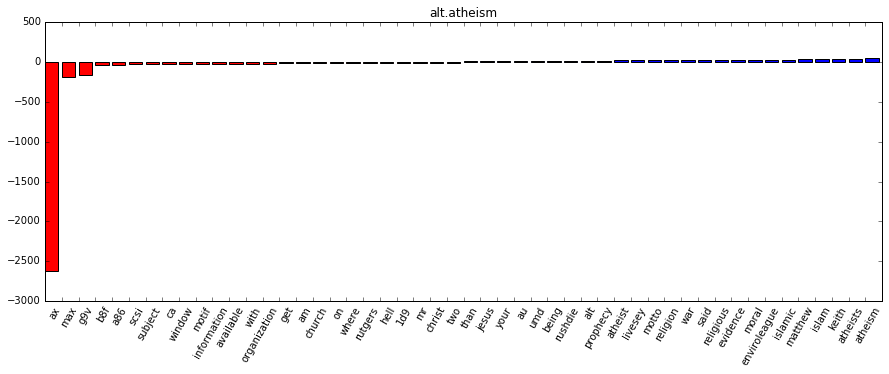

In [56]:
visualize_coefficients(logit_sgd.coef_[0,:], cv.get_feature_names(),
                      title=newsgroups['target_names'][0])

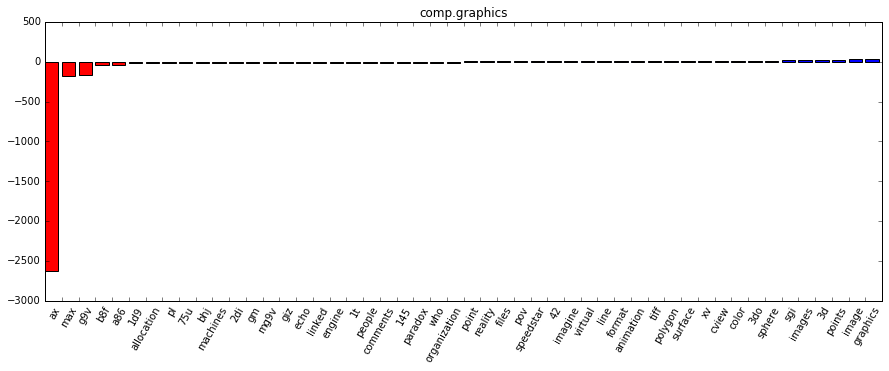

In [57]:
visualize_coefficients(logit_sgd.coef_[1,:], cv.get_feature_names(),
                      title=newsgroups['target_names'][1])

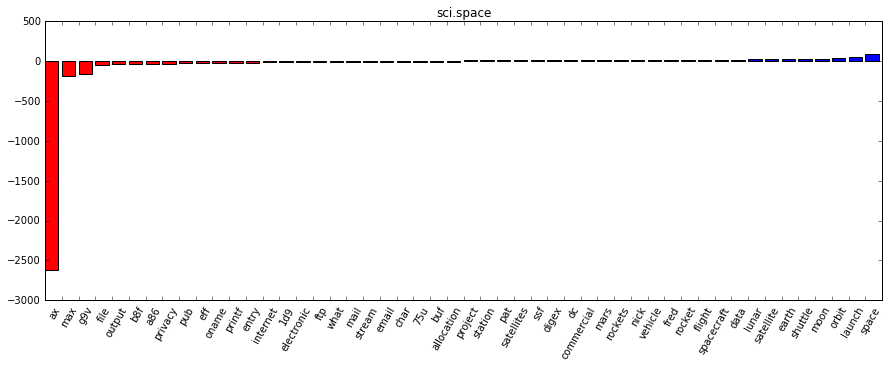

In [58]:
visualize_coefficients(logit_sgd.coef_[14,:], cv.get_feature_names(),
                      title=newsgroups['target_names'][14])

А получилось довольно круто, слова, повышающие вероятность принадлежности к классу, дейстивтельно относятся к данному классу, и это здорово

**Обучите случайный лес на всей выборке *(X_train, y_train)*. Сделайте прогнозы (именно вероятности) для отложенной выборки *X_valid*.**

In [59]:
rf_valid_pred = rf.predict_proba(X_valid)

**<font color='red'>Вопрос 3.</font> Какими получились доли правильных ответов на отложенной выборке у логистической регрессии (с SGD) и случайного леса? Округлите до 3 знаков после разделителя.**

In [60]:
get_accuracy_score(logit_sgd_valid_pred, y_valid)

0.754

In [61]:
get_accuracy_score(rf_valid_pred, y_valid)

0.63

По большому счету доля правильных ответов на тренировочных и валидационных данных практически не отличается, и логит регрессия по-прежнему впереди

**Напишем функцию для поиска на кросс-валидации лучшей линейной смеси ответов (вероятностей) логистической регрессии и леса. Смесь будет строиться такого вида: $p_{mix} = w_1 * p_{logit} + (1 - w_1) * p_{rf}$, где $p_{logit}$,$p_{rf}$ и $p_{mix}$ – матрицы предсказанных вероятностей для линейной модели, леса и их смеси соотв-но, $w_1 \in [0,1]$ – вес, с которым в композицию входят ответы линейной модели. Функция будет быстро работать, поскольку мы воспользуемся готовыми прогнозами и не будем обучать модели заново.**

In [62]:
def best_linear_mix(target, pred1, pred2):
    best_acc, best_w1 = 0, 0
    best_pred = pred1
    for w1 in np.linspace(0, 1, 20):
        curr_pred = w1 * pred1 + (1 - w1) * pred2
        curr_acc = accuracy_score(target, np.argmax(curr_pred, axis=1))
        if curr_acc >  best_acc:
            best_acc = curr_acc
            best_pred = curr_pred
            best_w1 = w1
    return best_acc, best_w1

**Вызовите функцию и сохраните результат в переменные *mix_cv_acc* (доля правильных ответов на кросс-валидации для смеси моделей) и *best_logit_weight* – лучшее значение веса, с которым в композицию будут входить ответы линейной модели.**

In [71]:
mix_cv_acc, best_logit_weight = best_linear_mix(y_train, logit_sgd_oof_pred, rf_oof_pred)

**<font color='red'>Вопрос 4.</font>. Какой получилась доля правильных ответов на кросс-валидации у лучшей (из перебранных) смеси ответоы линейной модели и леса? Округлите до 3 знаков после разделителя.**

In [72]:
round(mix_cv_acc, 3)

0.798

Ура, доля правильных подросла еще примерно на 0.03 по сравнению с нашей лучшей моделью - логитом

**<font color='red'>Вопрос 5.</font>. Каким получился вес ответов линейной модели в итоговой композиции? (ответ может удивить). Округлите до 3 знакок после разделителя.**

In [73]:
round(best_logit_weight, 3)

0.263

А отчет действительно удивил, несмотря на то, что логит у нас лидировал по качеству, в смесь он вошел с жалким весом в 0.26

**Посчитайте прогноз на отложенной выборке для лучшей (из перебранных) смеси ответов моделей. **

In [74]:
mix_valid_pred = best_logit_weight * logit_sgd_valid_pred + (1-best_logit_weight) * rf_valid_pred

**<font color='red'>Вопрос 6.</font>. Какой получилась доля правильных ответов на отложенной выборке у лучшей (из перебранных) смеси ответов линейной модели и леса? Округлите до 3 знака после разделителя.**

In [75]:
get_accuracy_score(mix_valid_pred, y_valid)

0.779

Круто, доля выросла где-то на 0.025 по сравнению с лучшим результатом логита. Смесь работает :)